In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [ ]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -U duckduckgo_search
    !pip install fastai
    !pip install fastbook

## Step 1: Download images of 10 classes

In [3]:
from fastbook import *
from fastai.vision.widgets import *

def search_images(term, max_images=100):
    print(f"Searching for '{term}'")
    return L(search_images_ddg(term, max_images=max_images))


In [4]:
from fastdownload import download_url
from fastai.vision.all import *

### Generate the CIFAR-10_like dataset to the path.

In [5]:
searches = 'airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'
path = Path('Ten Classes Dataset')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'airplane photo'
Searching for 'automobile photo'
Searching for 'bird photo'
Searching for 'cat photo'
Searching for 'deer photo'
Searching for 'dog photo'


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Searching for 'frog photo'
Searching for 'horse photo'
Searching for 'ship photo'
Searching for 'truck photo'


### Display the contents in path and the numbers of each class

In [ ]:
print(path)
searches = 'airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'

for imageType in searches:
    print(imageType)
    content = os.listdir(path/imageType)
    print(len(content))
    for element in content:
        print(element)

## Step 2: Dataset Preprocess

### Remove the missing photos

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

11

### Create the DataLoader to train models

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

None
None


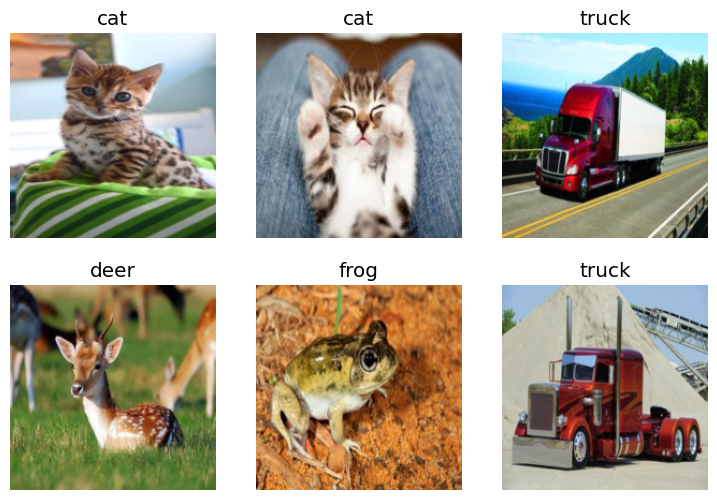

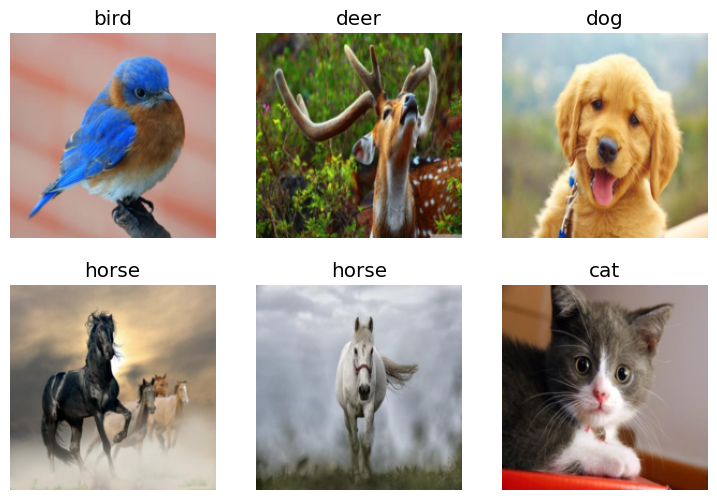

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

print(dls.train.show_batch(max_n=6))
print(dls.valid.show_batch(max_n=6))

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

## Step 3: Train our model

### Use the dataset to train the Resnet18 model.

In [9]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=accuracy)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s] 


### Find the best value of the learning rate.

SuggestedLRs(valley=0.0010000000474974513)

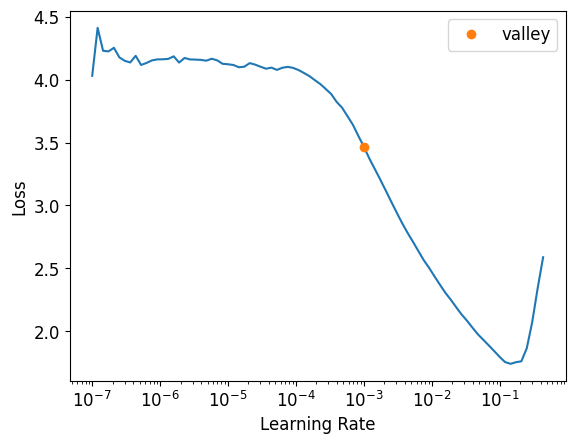

In [10]:
learn.lr_find()

### Adjust epochs and learning rate based on the findings above.

In [11]:
learn.fine_tune(10, base_lr=1e-3)  

epoch,train_loss,valid_loss,accuracy,time
0,2.191409,0.121911,0.957219,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.278890,0.058252,0.994652,00:03
1,0.181195,0.024202,1.000000,00:02
2,0.118507,0.018078,1.000000,00:02
3,0.070949,0.017253,0.994652,00:02
4,0.046314,0.011408,1.000000,00:02
5,0.031415,0.010030,1.000000,00:02
6,0.021996,0.010620,0.994652,00:02
7,0.018028,0.007566,1.000000,00:02
8,0.013510,0.007407,1.000000,00:03
9,0.010845,0.009355,1.000000,00:02


### Multiclass loss function

We use the function CrossEntropyLossFlat as our loss function. Cross-entropy loss measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So, for a perfect model, the cross-entropy loss would be 0.

Mathematically, the cross-entropy loss for a single data point is defined as:
$ L = -\sum_{c=1}^M y_{o,c} \log(p_{o,c}) $
where:
- $ M $ is the number of classes.
- $ y $ is a binary indicator (0 or 1) if class label $ c $ is the correct classification for observation $ o $.
- $ p $ is the predicted probability that observation $ o $ is of class $ c $.

## Step 4: Performance evaluation

### Confusion matrix

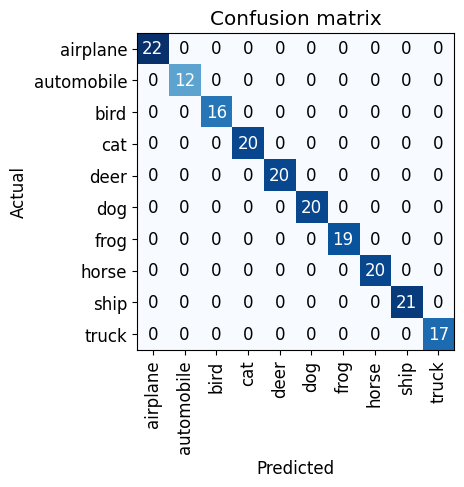

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

This confusion matrix is a visualization that helps to understand the performance of a classification model. Here's what we can infer from it:

1. **Diagonal Dominance**: The diagonal from top left to bottom right shows the number of correct predictions for each class. High numbers along this diagonal are indicative of better performance. Here, every class has a significant number of correct predictions, which is a good sign.

2. **Misclassifications**: The off-diagonal cells show the number of misclassifications. For example, there are cases where 'automobiles' were misclassified as 'airplanes', but the majority of errors seem to occur within the 'cat' and 'dog' classes. This is expected, as cats and dogs can be quite similar in appearance.

3. **Class-by-Class Performance**:
   - 'Airplane', 'ship', and 'truck' have the highest correct classifications, which suggests that the model can distinguish these categories quite well.
   - The classes 'cat' and 'dog' seem to be the most challenging for the model, with the highest number of misclassifications. This might be due to the visual similarities between these classes, which can confuse the model.

4. **No Significant Confusion Between Dissimilar Classes**: There doesn't seem to be any significant confusion between classes that are quite different from each other, such as 'airplane' and 'deer' or 'ship' and 'frog'. This suggests that the model has learned distinctive features for these classes quite well.

5. **Balanced Dataset**: All classes seem to have a similar number of samples, which is indicative of a balanced dataset. This is good because it means that the model's performance isn't biased towards a particular class due to sample size.

6. **Possible Improvements**:
   - We could potentially improve the classification performance between 'cats' and 'dogs' by providing more training data, applying more sophisticated data augmentation techniques, or even using a more complex model that can capture more nuanced differences between these classes.
   - Since there's a good distinction between other classes, focusing on the features that separate 'cats' and 'dogs' could also improve overall accuracy.

Based on this confusion matrix, we can conclude that the model performs well for most classes but could benefit from improvements in distinguishing between certain similar classes, such as 'cats' and 'dogs'.


### t-SNE

/tmp/ipykernel_34/4260576066.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')


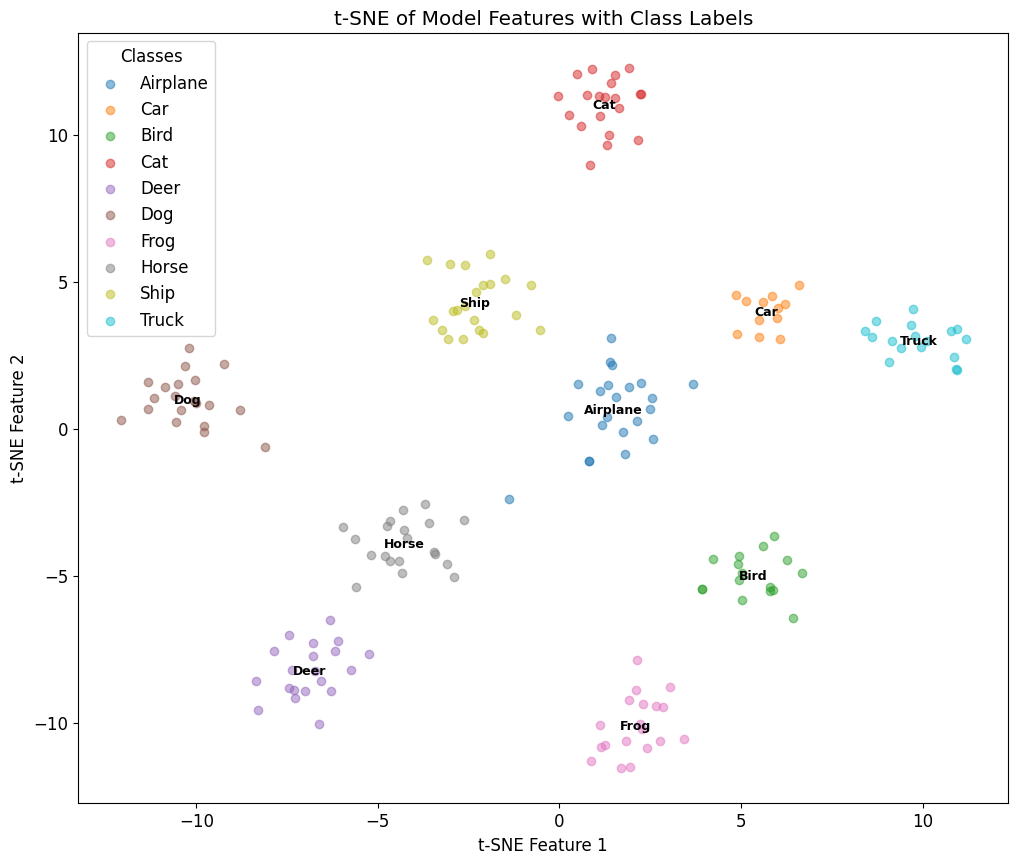

In [13]:
# Modifying the learner's model to return features
hook = hook_output(learn.model[1][4])  # Choosing an appropriate layer

# Getting features from the validation set
learn.model.eval()
features = []
labels = []

with torch.no_grad():
    for x, y in dls.valid:
        _ = learn.model(x)
        features.append(hook.stored.cpu())
        labels.extend(y.cpu())

features = torch.cat(features).cpu().numpy()
labels = np.array(labels)

class_names = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# We assume 'features' and 'labels' are already prepared as described previously
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
X_reduced = tsne.fit_transform(features)

# Plotting
plt.figure(figsize=(12, 10))
cmap = plt.cm.get_cmap('tab10')
scatter_plots = []

for i, class_name in enumerate(class_names):
    scatter = plt.scatter(X_reduced[labels == i, 0], X_reduced[labels == i, 1], 
                          c=np.array(cmap(i)).reshape(1, 4), label=class_name, alpha=0.5)
    scatter_plots.append(scatter)

# Adding legend with class names
plt.legend(handles=scatter_plots, title="Classes")

# Optionally adding annotations for each cluster's centroid or a representative point
for i, class_name in enumerate(class_names):
    centroid = X_reduced[labels == i].mean(axis=0)
    plt.text(centroid[0], centroid[1], class_name, horizontalalignment='center', verticalalignment='center', fontdict={'weight': 'bold', 'size': 9})

plt.title('t-SNE of Model Features with Class Labels')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()



The t-SNE visualization shows the separation of different classes in a two-dimensional space, which helps us understand how well the model distinguishes between them. Here's what we can conclude from this visualization:

1. **Class Separation**: Most classes form distinct clusters, indicating that the model is able to differentiate between them well. For instance, 'Ship', 'Truck', 'Car', and 'Airplane' clusters are quite separated from other classes, which suggests the model has learned unique features for these categories.

2. **Overlapping Clusters**: Some classes overlap significantly, such as 'Cat' and 'Dog', which was also indicated in the confusion matrix. This overlap suggests that the model may confuse these classes with one another, potentially due to similar features or insufficiently distinctive representations in the feature space.

3. **Compact Clusters**: Classes like 'Bird', 'Ship', and 'Truck' form tight clusters, implying that the images within each of these categories share strong similarities and the model recognizes these effectively.

4. **Outliers**: There are a few points that are positioned far from their primary cluster. For instance, there are a few 'Dog' data points scattered within the 'Horse' cluster. These could be misclassified instances or instances with features that are not typical for their class.

5. **Cluster Density**: The density of each cluster could provide insights into class variance, with denser clusters possibly representing less variance within that class from the model's perspective.

6. **Inter-Class Distances**: The distances between clusters can be indicative of how different the classes are from each other in the feature space learned by the model. For example, 'Airplane' and 'Truck' are farther apart, indicating distinct features, while 'Cat' and 'Dog' are closer, showing feature overlap.

7. **Model Interpretability**: This t-SNE plot can aid in interpretability. By examining which images are placed at the boundaries or within the wrong clusters, you can gain insights into what the model is learning and where it may be failing.

Based on this t-SNE visualization, we can conclude that while the model has learned to differentiate between several classes effectively, there are particular areas, such as distinguishing between 'Cats' and 'Dogs,' that may need further improvement, perhaps through more targeted data or feature engineering.


### Final accuracy

In [14]:
learn.validate()

(#2) [0.00935510452836752,1.0]

From above we can easily know that the accuracy is already 100%, which means that this model is such a good model to classify the generated dataset.